# TUTORIAL: 
# Data assimilation using real experimental data

We can now put everything we have learned together. 

We can investigate two scenarios:

A) Assume that we have access to the post-processed data and assimilate it. This situation simplifies the problem as the experimental data is not biased (see tutorial TA_azimuthal_data to see how the raw data is biased).
-   Truth: post-processed data 
-   Observations: post-processed data + noise (possibly coloured noise)

B) Assume a realistic setting in which the post-processed data is not available on the fly to input to the data assimilation algorithm. Here, we need to address the issue of biased observations.
-   Truth: post-processed data
-   Observations: raw data

In this tutorial we will work with option B. For option A go to the tutorial ```10_DA_annular_ideal.ipynb```.

In [1]:
import essentials.DA
%matplotlib inline

import parent_folders # workaround path issue in jupyter notebook

import numpy as np
import os

rng = np.random.default_rng(0)


if os.path.isdir('/mscott/'):
    data_folder = '/mscott/an553/data/'  # set working directory to 
else:
    data_folder = "../data/"

## 1. Load data 
Create the reference truth and the observations.


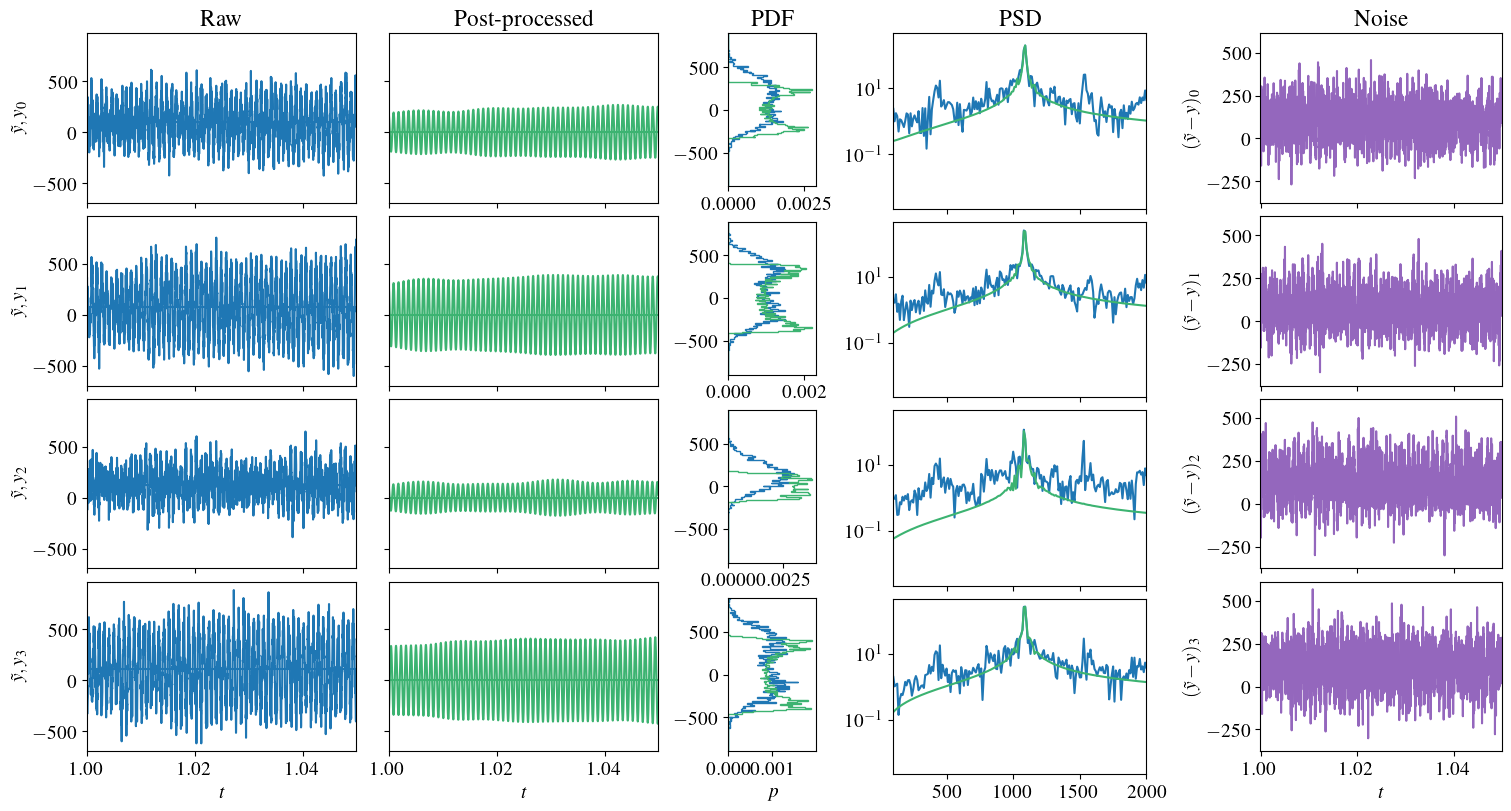

In [2]:
from essentials.create import create_truth
from essentials.physical_models import Annular
from essentials.plotResults import plot_truth

ER = 0.5125   # .4875 .5125 .5375 .5625
filename = data_folder + 'annular/ER_{}'.format(ER)

# Select the observations time-window
t_start = 1.0
t_stop = t_start + Annular.t_CR * 5
t_max = t_stop + Annular.t_CR * 5
Nt_obs = 35

truth = create_truth(filename, t_start=t_start, t_stop=t_stop, t_max=t_max, dt_obs=Nt_obs, post_processed=False)
plot_truth(**truth)


## 2. Define the forecast model
This is the physical model which we will use to model the true data.
Here, we select the filter parameters and create ensemble


In [3]:

nu = Annular.nu_from_ER(ER)
c2beta = Annular.c2beta_from_ER(ER)

print(nu, c2beta)

-6.582875000000001 24.10875


In [4]:
from essentials.create import create_ensemble


nu = Annular.nu_from_ER(ER)
c2beta = Annular.c2beta_from_ER(ER)

filter_params = {'m': 20, 
                 'inflation': 1.002,
                 'std_psi': 0.3,
                 'std_a': dict(nu=(-5., 20.),
                               c2beta=(c2beta-10, c2beta+10),
                               kappa=(1.E-4, 1.3E-4),
                               epsilon=(0.0001, 0.03),
                               omega=(1090 * 2 * np.pi, 1100 * 2 * np.pi),
                               theta_b=(0.5, 0.7),
                               theta_e=(0.5, 0.8)
                               )}

ensemble = create_ensemble(model=Annular, **filter_params)

ensemble_no_bias = ensemble.copy()
ensemble_ESN = ensemble.copy()


## 4. Train an ESN to model the model bias
The procedure is the following

&emsp; i. Initialise ESN Bias class object
&emsp; ii. Create synthetic bias to use as training data 
&emsp; iii. Train the ESN
&emsp; iv. Create washout data

sparsity =  0.9387755102040817
rho =  1.1112487908100044

 ----------------- HYPERPARAMETER SEARCH ------------------
 4x4 grid and 4 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 5.000e-01	 1.000e-06	 1.000e-16	 -4.9418
2	 5.000e-01	 2.154e-05	 1.000e-16	 -4.4617
3	 5.000e-01	 4.642e-04	 1.000e-16	 -4.6106
4	 5.000e-01	 1.000e-02	 1.000e-12	 -4.5507
5	 6.000e-01	 1.000e-06	 1.000e-16	 -4.8698
6	 6.000e-01	 2.154e-05	 1.000e-16	 -4.4419
7	 6.000e-01	 4.642e-04	 1.000e-16	 -4.5812
8	 6.000e-01	 1.000e-02	 1.000e-12	 -4.5283
9	 7.000e-01	 1.000e-06	 1.000e-16	 -4.7404
10	 7.000e-01	 2.154e-05	 1.000e-16	 -4.4514
11	 7.000e-01	 4.642e-04	 1.000e-12	 -4.5945
12	 7.000e-01	 1.000e-02	 1.000e-12	 -4.5959
13	 8.000e-01	 1.000e-06	 1.000e-16	 -4.6730
14	 8.000e-01	 2.154e-05	 1.000e-16	 -4.5705
15	 8.000e-01	 4.642e-04	 1.000e-12	 -4.6391
16	 8.000e-01	 1.000e-02	 1.000e-12	 -4.6041
17	 5.000e-01	 1.115e-06	 1.000e-16	 -4.9385
18	 5.000e-01	 2.409e-06	 1.000e-16	 -4.816

/home/an553/anaconda3/envs/C-EnKF/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


20	 5.000e-01	 1.000e-06	 1.000e-16	 -4.9442

 Time per hyperparameter eval.: 6.82517192363739 
 Best Results: x 
	 5.00e-01	 1.00e-06	 1.00e-16 f 4.9442
Median and max error in 10 tests: -1.9448233015417289 -1.4714127715144152


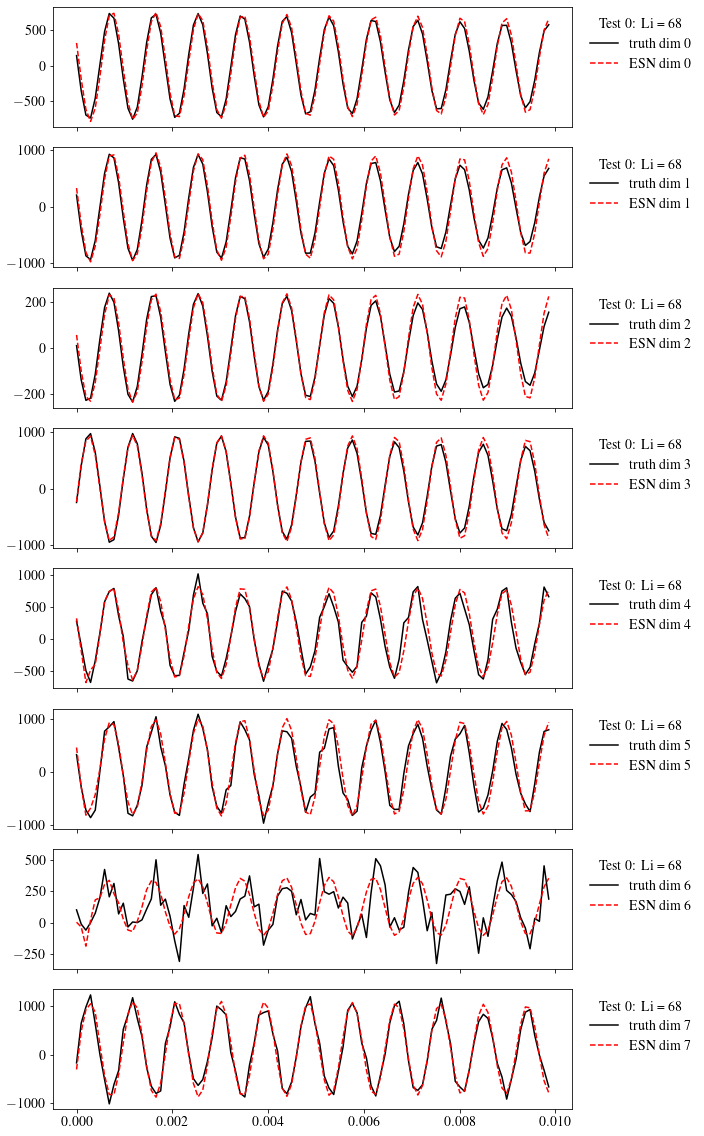

In [5]:
from essentials.create import create_bias_training_dataset, create_washout
from essentials.bias_models import ESN

train_params = dict(bias_model=ESN, 
                    upsample=5,
                    N_units=50,
                    N_wash=3,
                    t_train=ensemble.t_CR * 10,
                    t_val=ensemble.t_CR * 1,
                    # Bayesian update to the ESN state
                    bayesian_update=True,
                    biased_observations=True,
                    update_reservoir=True,
                    inflation=1.01,
                    filter=essentials.DA.EnSRKF,
                    m=10,
                    # Training data generation options
                    augment_data=True,
                    L=30,
                    N_folds=4,
                    noise=0.01,
                    # Hyperparameter search ranges
                    rho_range=(0.5, .8),
                    sigma_in_range=(np.log10(1e-6), np.log10(1e-2)),
                    tikh_range=[1e-16, 1e-12]
                    )

# 4.1. Initialise the ESN
ensemble_ESN.init_bias(**train_params)

# 4.2. Create training data
train_data = create_bias_training_dataset(truth['y_raw'], truth['y_true'], ensemble_ESN, **train_params)


# 4.3. Train the ESN
# The training convergence, hyperparameter optimization and testing results are saved in a pdf file in figs_ESN folder.
ensemble_ESN.bias.train_bias_model(**train_data) 

# 4.4. Create washout data
ensemble_ESN.t_init = truth['t_obs'][0]
ensemble_ESN.bias.t_init = ensemble_ESN.t_init - 2 * Nt_obs * truth['dt']
wash_t, wash_obs = create_washout(bias_case=ensemble_ESN.bias, **truth)



## 5. Apply data assimilation
We now have all the ingredients to start our data assimilation algorithm.


 ------------------ Annular Model Parameters ------------------ 
	 ER = 0.5
	 Nq = 4
	 c2beta = 24.1088
	 dt = 1.95313e-05
	 epsilon = 0.01505
	 kappa = 0.000115
	 n = 1.0
	 nu = 7.5
	 omega = 6880.09
	 theta_b = 0.6
	 theta_e = 0.65

 ---------------- NoBias bias model parameters --------------- 
	 N_ens = 1
	 bayesian_update = False
	 biased_observations = False
	 upsample = 1

 -------------------- ASSIMILATION PARAMETERS -------------------- 
 	 Filter = EnKF  
	 bias = NoBias 
 	 m = 20 
 	 Time steps between analysis = None 
 	 Inferred params = ['nu', 'c2beta', 'kappa', 'epsilon', 'omega', 'theta_b', 'theta_e'] 
 	 Inflation = 1.0 
 	 Ensemble std(psi0) = 0.3
 	 Ensemble std(alpha0) = {'nu': (-5.0, 20.0), 'c2beta': (14.10875, 34.10875), 'kappa': (0.0001, 0.00013), 'epsilon': (0.0001, 0.03), 'omega': (6848.671984825749, 6911.503837897545), 'theta_b': (0.5, 0.7), 'theta_e': (0.5, 0.8)}
 	 Number of analysis steps = 74, t0=0.99998046875, t1=1.0498828125
 --------------------------

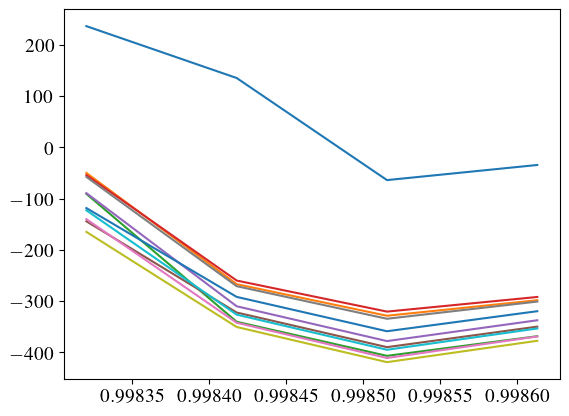

Elapsed time to first observation: 4.536425590515137 s
Assimilation progress: 
	0 % 9% 19% 28% 38% 47% 57% 66% 76% 85% 100% ----------------

Elapsed time during assimilation: 5.05705714225769 s


In [123]:
from essentials.DA import dataAssimilation

std_obs = 0.05


ensemble_ESN.filter = 'rBA_EnKF'
ensemble_ESN.regularization_factor = 1.

ensemble_no_bias.filter ='EnKF'


kwargs = dict(y_obs=truth['y_obs'], t_obs=truth['t_obs'], std_obs=std_obs, wash_obs=wash_obs, wash_t=wash_t)

out = []
for ens in [ensemble_no_bias, ensemble_ESN]:
# for ens in [ensemble_ESN]:
    ens = ens.copy()
    ens.inflation = 1.0
    ens.bias.inflation = 1.1
    ens.bias.update_reservoir = True
    filter_ens = dataAssimilation(ens, **kwargs.copy())
    
    #Forecast the ensemble further without assimilation
    Nt_extra = int((t_max - ens.t) / filter_ens.dt)
    
    psi, t = filter_ens.time_integrate(Nt_extra)
    filter_ens.update_history(psi, t)
    
    y = filter_ens.get_observable_hist(Nt_extra)
    b, t_b = filter_ens.bias.time_integrate(t=t, y=y)
    filter_ens.bias.update_history(b, t_b)
    
    out.append(filter_ens)
    # out[-1] = filter_ens


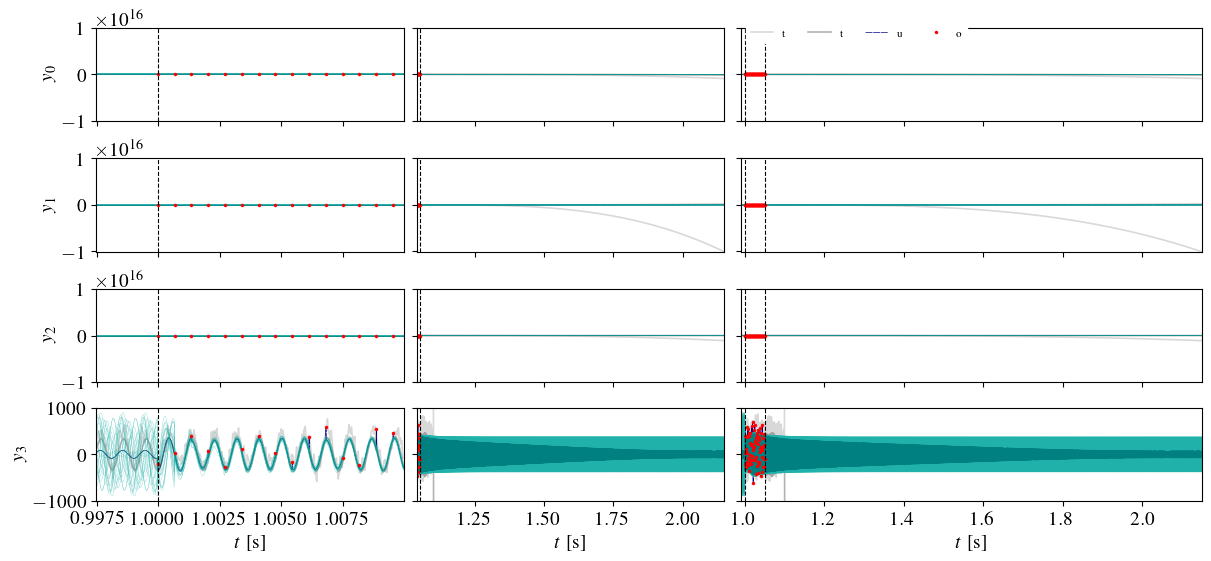

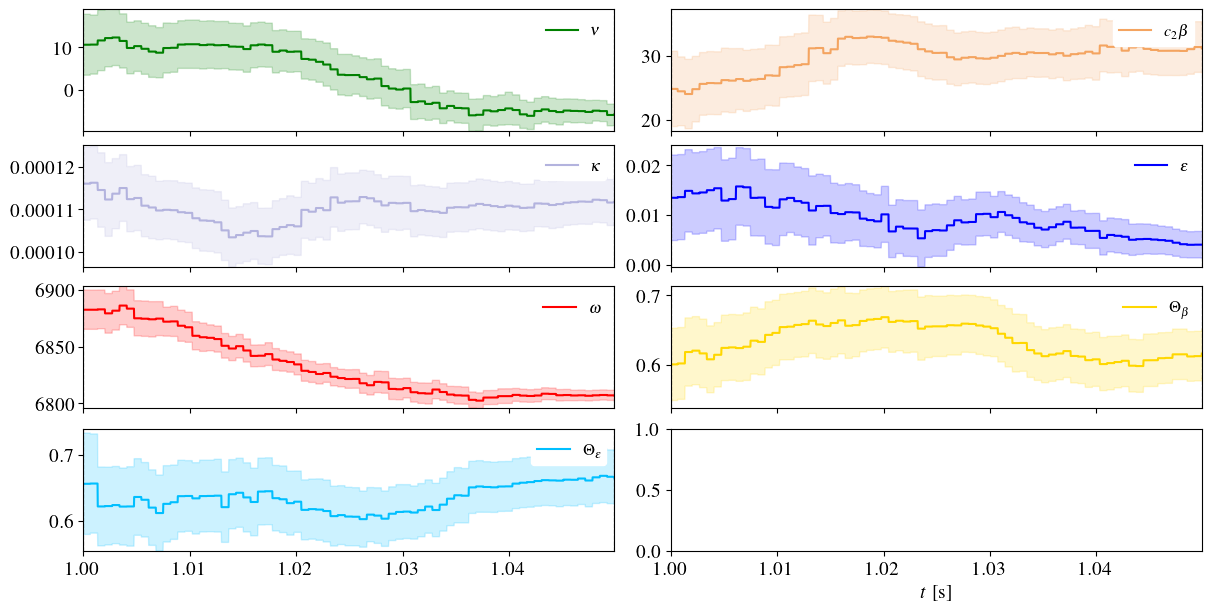

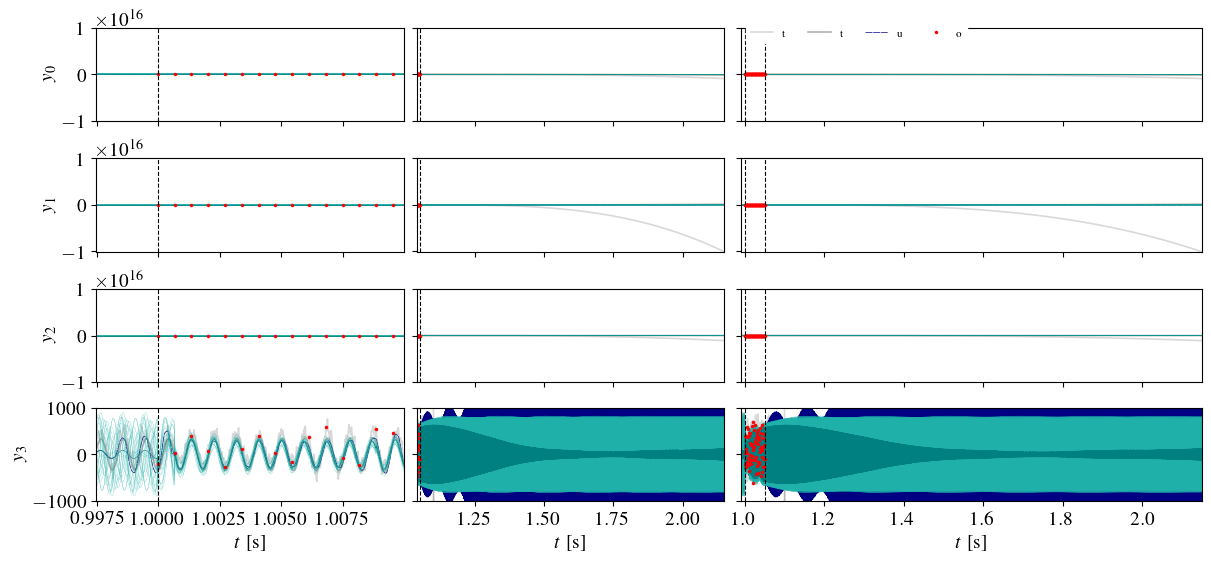

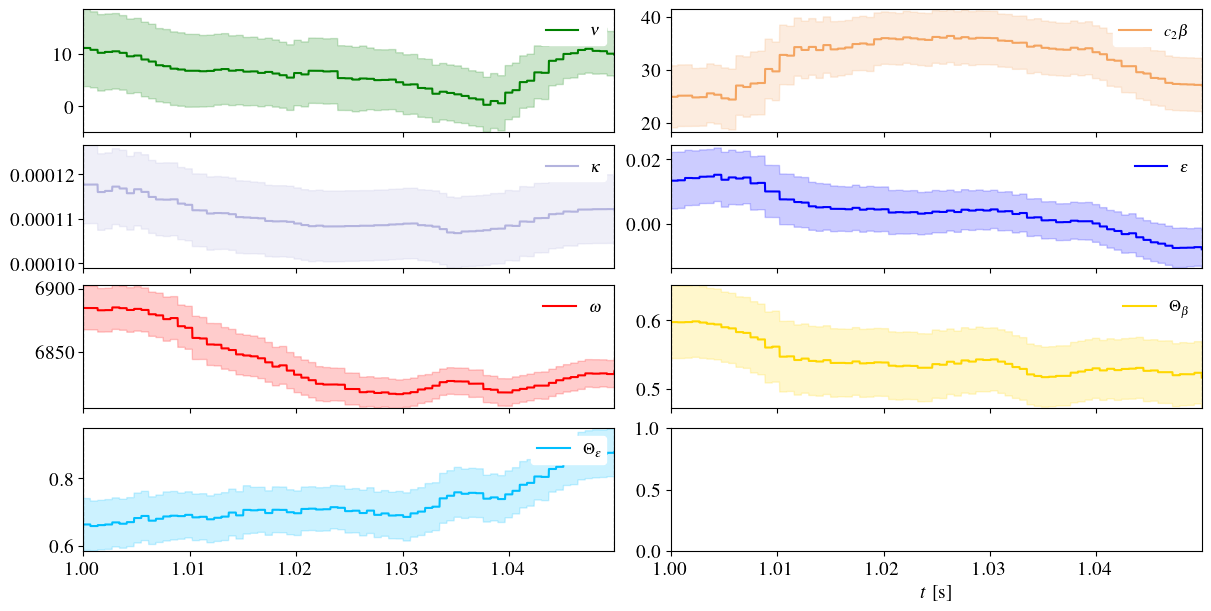

In [130]:
from essentials.plotResults import plot_timeseries, plot_parameters

%matplotlib inline
# %matplotlib qt

for filter_ens in out:
    plot_timeseries(filter_ens, truth)
    ax=plt.gca()
    ax.set(ylim=[-1e3, 1e3])
    plot_parameters(filter_ens, truth)

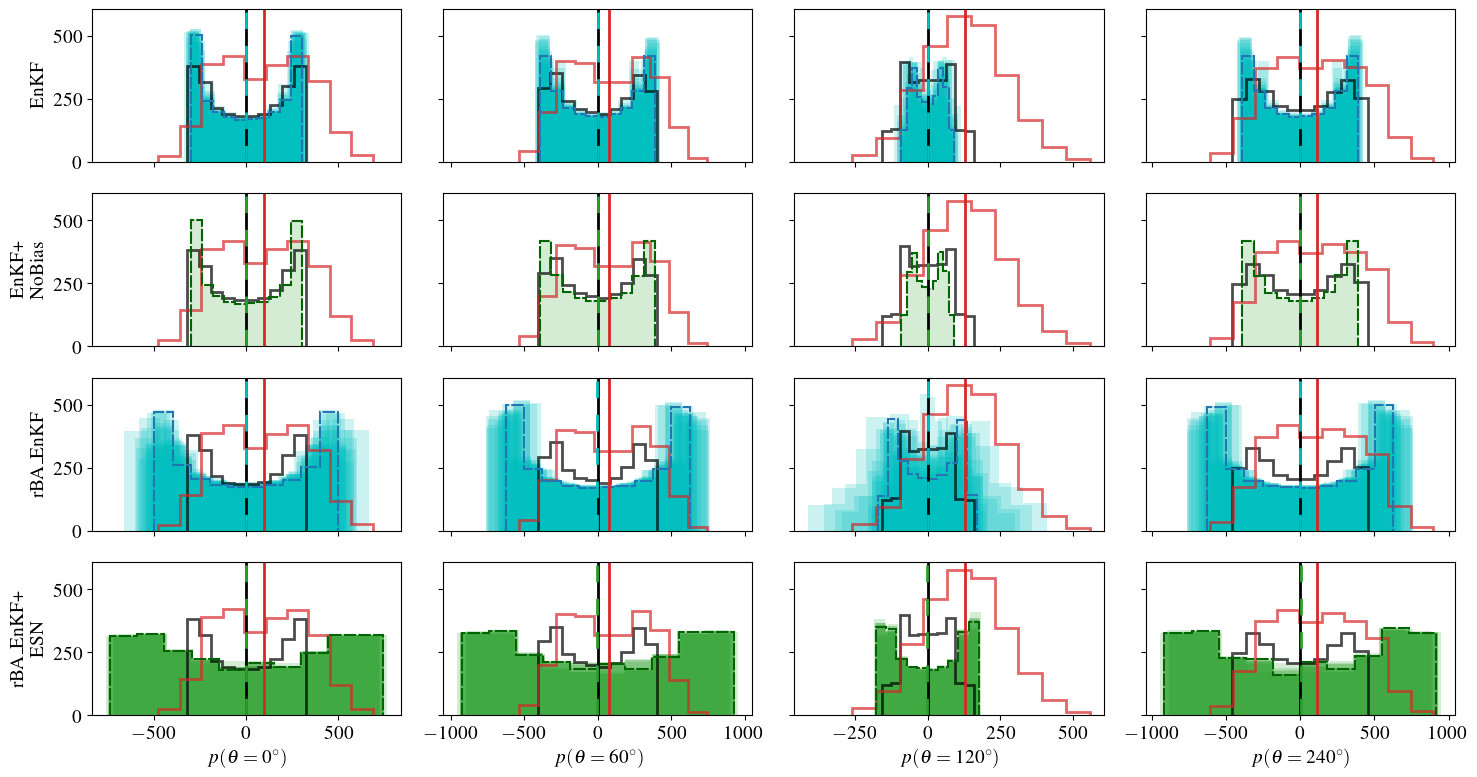

In [129]:
# from essentials.plotResults import plot_states_PDF, plot_RMS_pdf

window = (truth['t_obs'][-1], t_max)

plot_states_PDF(out, truth, nbins=10, window=window)
# plot_RMS_pdf(out, truth, nbins=10)


In [128]:


def plot_states_PDF(ensembles, truth, nbins=20, window=None):
    if type(ensembles) is not list:
        ensembles = [ensembles]

    Nq = truth['y_true'].shape[1]
    fig, axs_all = plt.subplots(nrows=2 * len(ensembles), ncols=Nq, sharex='col', sharey=True,
                                figsize=(15, 4 * len(ensembles)), layout='tight')

    if window is None:
        window = (truth['t_obs'][-1], ensembles[0].hist_t[-1])

    j0, j1 = [np.argmin(abs(truth['t'] - tt)) for tt in window]
        
    t_ref, y_ref_true, y_ref_raw = [truth[key][j0:j1] for key in ['t', 'y_true', 'y_raw']]

    
    args_1 = dict(orientation='vertical', histtype='step', bins=nbins, density=False)
    args_2 = dict(orientation='vertical', histtype='stepfilled', bins=nbins, density=False)

    ii = -2
    for ens in ensembles:
        ii += 2

        y_est = ens.get_observable_hist()
        y_est = interpolate(ens.hist_t, y_est, t_ref)

        # Plot bias-corrected solutions
        b_est = ens.bias.get_bias(state=ens.bias.hist, mean_bias=False)
        y_mean = np.mean(y_est, axis=-1, keepdims=True)
        if ens.bias.name != 'NoBias':
            y_est_u = interpolate(t_ref, y_mean, ens.bias.hist_t) + b_est
            y_est_u = interpolate(ens.bias.hist_t, y_est_u, t_ref)
        else:
            y_est_u = y_mean

        for yy, axs_, c in zip([y_est, y_est_u], [axs_all[ii], axs_all[ii + 1]],
                               [['c', 'tab:blue'], ['tab:green', 'darkgreen']]):
            for qi, ax in enumerate(axs_):
                for mi in range(yy.shape[-1]):
                    ax.hist(yy[:, qi, mi], color=c[0], alpha=0.2, **args_2)
                ax.hist(y_ref_true[:, qi], color='k', alpha=0.7, lw=2, **args_1)
                ax.hist(y_ref_raw[:, qi], color='tab:red', alpha=0.7, lw=2, **args_1)
                ax.hist(np.mean(yy[:, qi], axis=-1), color=c[1], alpha=1, ls=(0, (6, 1)), lw=1.5, **args_1)
                ax.axvline(np.mean(y_ref_true[:, qi]), color='k', ls='-', lw=2)
                ax.axvline(np.mean(y_ref_raw[:, qi]), color='tab:red', ls='-', lw=2)
                ax.axvline(np.mean(yy[:, qi]), color=c[0], ls=(0, (6, 6)), lw=2)

        axs_all[ii, 0].set(ylabel=ens.filter)
        axs_all[ii + 1, 0].set(ylabel='{}+\n{}'.format(ens.filter, ens.bias.name))

    for ax, lbl in zip(axs_all[-1, :], ens.obs_labels):
        ax.set(xlabel=lbl)


